In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from time import time
import matplotlib.pyplot as plt

import data_preprocessing as dp
import utils
from models.ResNet import ResNet
import train_zsl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))
torch.manual_seed(0)

Google word embeddings loaded
cuda:0
Quadro GV100


In [2]:
train_ds, valid_ds, zsl_ds = dp.create_datasets()

Train set images: 75000
Validation set images: 7500


In [3]:
batch_size = 512*4
num_epochs = 50
max_lr = 0.001
coef = 1

In [4]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size*2, shuffle=True, num_workers=16, pin_memory=True)

In [5]:
net = ResNet(3, 150)
net = nn.DataParallel(net, device_ids=['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'])
net = net.to(device)

In [6]:
utils.test_model(ResNet, num_examples=batch_size, input_size=64)

Random batch of size 2048 output shape: torch.Size([2048, 150])
Forward pass ran in 11.31 seconds


In [7]:
label_vecs, target_labels, zsl_label_vecs, zsl_target_labels, train_target_vectors_norm = dp.preprocess_labels(train_ds, zsl_ds)

Categories split into seen and unseen
Labels transformed into average labels
Label vectors preprocessed
Target vectors normalized


In [8]:
results_1, lrs_1 = train_zsl.train_zsl(net, num_epochs, train_loader, val_loader, 
                                       label_vecs, target_labels, max_lr=max_lr,
                                       crit='mse', coef=coef, scheduler='one', cycles=1)

Epoch[0] Train_loss: 5.6288  Val_loss: 5.5307 Val_CE: 4.8629 Val_vec_loss: 0.6678	 Train_acc: 0.0151  Val_acc: 0.0260 LR: 0.00005 time: 57.44
Epoch[1] Train_loss: 5.4281  Val_loss: 5.3583 Val_CE: 4.6937 Val_vec_loss: 0.6646	 Train_acc: 0.0270  Val_acc: 0.0456 LR: 0.00008 time: 41.14
Epoch[2] Train_loss: 5.2469  Val_loss: 5.1828 Val_CE: 4.5260 Val_vec_loss: 0.6568	 Train_acc: 0.0432  Val_acc: 0.0623 LR: 0.00013 time: 42.62
Epoch[3] Train_loss: 5.0655  Val_loss: 4.9740 Val_CE: 4.3330 Val_vec_loss: 0.6410	 Train_acc: 0.0645  Val_acc: 0.0935 LR: 0.00020 time: 43.14
Epoch[4] Train_loss: 4.8868  Val_loss: 4.7643 Val_CE: 4.1339 Val_vec_loss: 0.6303	 Train_acc: 0.0897  Val_acc: 0.1116 LR: 0.00028 time: 43.99
Epoch[5] Train_loss: 4.6608  Val_loss: 4.5891 Val_CE: 3.9727 Val_vec_loss: 0.6165	 Train_acc: 0.1104  Val_acc: 0.1392 LR: 0.00037 time: 44.33
Epoch[6] Train_loss: 4.5694  Val_loss: 4.3941 Val_CE: 3.7950 Val_vec_loss: 0.5991	 Train_acc: 0.1316  Val_acc: 0.1618 LR: 0.00047 time: 44.63
Epoch[

In [9]:
max_lr = 0.0001
num_epochs = 5
checkpoint = torch.load('./model_weights/model_weights.pth')
net.load_state_dict(checkpoint['model_state_dict'])
results_2, lrs_2 = train_zsl.train_zsl(net, num_epochs, train_loader, val_loader, 
                                       label_vecs, target_labels, max_lr=max_lr,
                                       crit='mse', coef=coef, scheduler='cos', cycles=1)

Epoch[0] Train_loss: 1.4217  Val_loss: 2.3093 Val_CE: 2.0702 Val_vec_loss: 0.2390	 Train_acc: 0.7196  Val_acc: 0.5197 LR: 0.00009 time: 46.34
Epoch[1] Train_loss: 1.2887  Val_loss: 2.3213 Val_CE: 2.0810 Val_vec_loss: 0.2402	 Train_acc: 0.7467  Val_acc: 0.5212 LR: 0.00007 time: 49.73
Epoch[2] Train_loss: 1.1692  Val_loss: 2.3168 Val_CE: 2.0756 Val_vec_loss: 0.2412	 Train_acc: 0.7583  Val_acc: 0.5211 LR: 0.00003 time: 45.37
Epoch[3] Train_loss: 1.2169  Val_loss: 2.3362 Val_CE: 2.0946 Val_vec_loss: 0.2416	 Train_acc: 0.7682  Val_acc: 0.5237 LR: 0.00001 time: 46.07
Epoch[4] Train_loss: 1.2131  Val_loss: 2.3104 Val_CE: 2.0688 Val_vec_loss: 0.2416	 Train_acc: 0.7736  Val_acc: 0.5266 LR: 0.00000 time: 45.37
Max validation accuracy: 0.5266


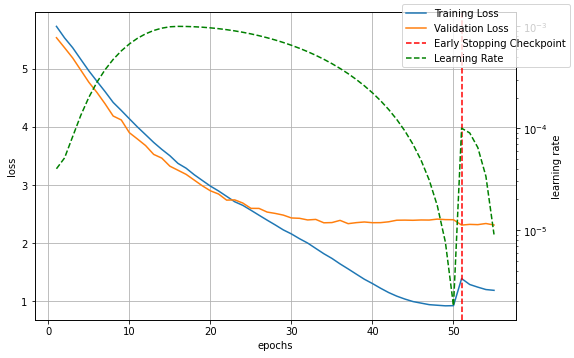

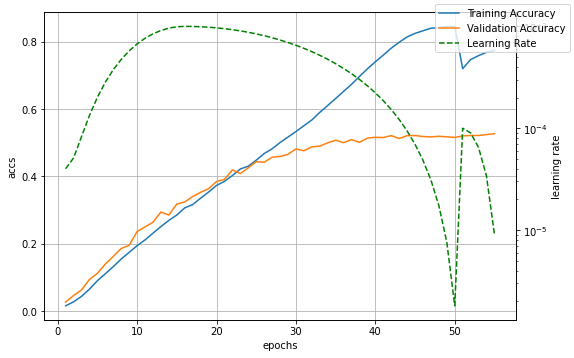

In [10]:
results = results_1 + results_2
lrs = torch.cat((lrs_1, lrs_2))
utils.plot_losses(results, lrs, train_loader, figsize=(8, 5))
utils.plot_accuracies(results, lrs, train_loader, figsize=(8, 5))